# Auto Encoder

오토인코더는 인코더와 디코더 두 개의 신경망으로 구성된 매우 간단한 네트워크입니다. 흔히 다음과 같은 모양으로 생겼습니다.

![](resources/autoencoder.jpg)

오토인코더가 작은 차원으로 데이터를 압축시키고 디코더가 원래 데이터로 복원시키는 것인데요, 이것은 데이터의 압축에 쓰일 수 있을 것이라고 직감할 수 있을 겁니다. 중요한 것은, 인코더가 데이터의 latent를 학습할 수 있다는 점입니다.

이것은 인코더가 데이터의 필요없는 노이즈를 없애버리고 데이터를 표현하는 핵심적인 부분을 학습할 수 있도록 도와줍니다. 나중에 디코더는 버리고 인코더를 feature extractor로 사용하여 supervised learning을 돕는 용도로 사용할 수 있을 겁니다.

## Implementation

다음 코드는 GPU가 여러개 있을 때, 2번 GPU만 보이도록 하는 것입니다. GPU가 여러개 있는 연구실같은 환경에서는 나눠써야겠죠? 혼자 다 쓰면 안됩니다. 저는 2번 GPU만 사용하도록 하겠습니다.

In [1]:
import os

# 환경변수 추가
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

CUDA_VISIBLE_DEVICES라는 환경 변수로 GPU의 인덱스만 추가해주면, CUDA 라이브러리가 해당 환경변수를 참조하여 그 GPU만 사용하도록 합니다.
주의할 점은, 반드시 CUDA를 사용하는 패키지를 임포트하기 전에 환경변수를 추가해 주어야 합니다. tensorflow, pytorch같은 라이브러리를 임포트하기 전에 이 작업을 수행해야 합니다.

### Library Import

필요한 라이브러리들을 임포트합니다.

In [2]:
import numpy as np # 선형대수 및 수치계산
import matplotlib.pyplot as plt # 시각화
import tensorflow as tf # 딥러닝 라이브러리

# 딥러닝
from tensorflow.keras import layers, models, datasets, optimizers, losses, metrics

그 다음으로, 필요한 hyper parameter를 설정합니다. Learning rate ETA의 경우, 일부러 작게 설정했습니다. ``1e-2``로 해도 돌아갑니다만, 너무 빨리 학습되어서 학습 과정을 시각화할 수 없었기에 일부러 작게 했습니다. 실전에서는 크게 주면 됩니다.

In [3]:
ETA = 1e-5
EPOCHS = 10
BATCH_SIZE = 128

### Dataset & Dataloader

텐서플로에서 제공하는 MNIST 데이터셋을 로드하고 데이터 로더를 생성합니다.

In [4]:
trainset, testset = datasets.mnist.load_data()

``mnist.load_data()``의 반환형은 ``(x_train, y_train), (x_test, y_test)``입니다. 그래서 이 코드는 다음과 같은 효과를 갖죠
```python
trainset = (x_train, y_train)
testset = (x_test, y_test)
```

In [5]:
trainloader = tf.data.Dataset.from_tensor_slices(trainset).batch(BATCH_SIZE).shuffle(4096)
testloader = tf.data.Dataset.from_tensor_slices(testset).batch(BATCH_SIZE)

데이터로더의 경우, 복잡해보일 수 있는데요, 텐서플로 Dataset을 만드는 방법에는 여러가지가 있습니다만, Dataset 클래스 메소드로 ``from_tensor_slices``라는 메소드를 사용하게 되면 ``(np.ndarray, np.ndarray)`` 형태의 튜플을 입력으로 받아서 텐서플로 Dataset 객체를 생성해 줍니다. 이때, 첫번째 ``np.ndarray``는 데이터($x$), 두번째는 라벨 정보가 들어가면 됩니다.

이때, trainset은 이미 ``(x, y)``의 형태이므로 그냥 ``from_tensor_slices``의 인자로 바로 넣을 수 있습니다.

Dataset의 인스턴스 메소드로 ``batch``, ``shuffle``이라는 메소드가 있는데요, 텐서플로 데이터로더는 기본적으로 데이터를 1개씩만 로드합니다. 하지만, Dataset객체의 ``batch(BATCH_SIZE)`` 메소드를 호출하게 되면, 같은 Dataset이지만, 나중에 로드할때 한번에 ``BATCH_SIZE``개수만큼 로드하는 Dataset을 반환해줍니다. ``shuffle``은 데이터셋을 1 epochs마다 셔플해주는 Dataset 객체를 반환해줍니다. 이때, ``shuffle``의 인자는 버퍼크기로, 셔플 속도에 영향을 주는 듯 합니다.

이제, 오토인코더를 구현해보겠습니다. 다음은 인코더가 3개층 convolution layer로 구성되고 디코더도 3개층 transpose convolution layer로 구성되는 오토인코더입니다. convolution은 down sampling을 할 수 있지만, convolution transpose는 up sampling을 할 수 있습니다.

In [6]:
class AutoEncoder(models.Model):
    """
    오토인코더
    """
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = models.Sequential([
            layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
        ])
        
        self.decoder = models.Sequential([
            layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.sigmoid),
        ])
        
    def call(self, x, training=False):
        latent = self.encoder(x, training=training)
        x_rec = self.decoder(latent, training=training)
        
        return x_rec

이제 오토인코더 객체를 만들고, loss, metric, optimizer 객체를 만들어 보겠습니다.

In [7]:
autoencoder = AutoEncoder()
criterion = losses.MeanSquaredError()

train_loss_obj = metrics.Mean()
test_loss_obj = metrics.Mean()

optimizer = optimizers.Adam(learning_rate=ETA)

다음은 배치 1개에 대해 학습하는 함수와 테스트하는 함수입니다.

In [8]:
def train_step(x):
    """
    1 배치에 대한 학습
    
    Arguments:
    ----------
    - x: 이미지 배치 (batch_size, 28, 28, 1)
    """
    
    # forward propagation
    with tf.GradientTape() as tape:
        x_rec = autoencoder(x, training=True)
        loss = criterion(x, x_rec)
        
    # compute gradients
    grads = tape.gradient(loss, autoencoder.trainable_variables)
    
    # apply gradients (weight update)
    optimizer.apply_gradients(zip(grads, autoencoder.trainable_variables))
    
    # accumulate loss for logging
    train_loss_obj.update_state(loss)

In [9]:
def test_step(x):
    """
    1 배치에 대한 테스트
    
    Arguments:
    ----------
    - x: 이미지 배치 (batch_size, 28, 28, 1)
    """
    
    # forward propagation without computing gradients
    x_rec = autoencoder(x, training=False)
    
    # compute loss
    loss = criterion(x, x_rec)
    
    # accumulate loss for logging
    test_loss_obj.update_state(loss)

In [10]:
def plot(x):
    """
    디코더로 복원된 이미지를 출력(테스트용)
    
    Arguments:
    ----------
    - x: 이미지 배치 (batch_size, 28, 28, 1)
    """
    
    # forward propagation (reconstruction)
    x_rec = autoencoder(x, training=False)
    
    # convert x_rec into numpy array
    x_numpy = x.numpy()
    x_rec_numpy = x_rec.numpy()
    
    # random index
    index = np.random.randint(x_numpy.shape[0])
    
    # plot
    plt.figure(figsize=(4, 2))
    
    plt.subplot(1, 2, 1)
    plt.imshow(x_numpy[index].squeeze(), cmap="gray")
    plt.title("original")
    
    plt.subplot(1, 2, 2)
    plt.imshow(x_rec_numpy[index].squeeze(), cmap="gray")
    plt.title("reconstructed")
    
    plt.show()

In [11]:
def train():
    """
    오토인코더 학습
    """
    
    # epochs
    for e in range(EPOCHS):
        
        # load all batch from train set
        for x, _ in trainloader:
            x = tf.cast(x, dtype=tf.float32)/256
            x = tf.expand_dims(x, axis=-1)
            
            train_step(x)
            
        cnt = 0
            
        # load all batch from test set
        for x, _ in testloader:
            x = tf.cast(x, dtype=tf.float32)/256
            x = tf.expand_dims(x, axis=-1)
            
            test_step(x)
            
            # plot 1 image
            if cnt < 1:
                plot(x)
                cnt += 1
                
        # get accumulated loss from loss obj
        train_loss = train_loss_obj.result()
        test_loss = test_loss_obj.result()
        
        # clear accumulated loss
        train_loss_obj.reset_states()
        test_loss_obj.reset_states()
        
        print(f"Epochs {e+1}/{EPOCHS}, train loss: {train_loss:.6f}, test loss: {test_loss:.6f}")

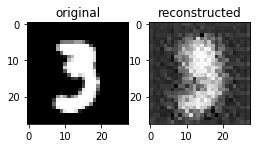

Epochs 1/10, train loss: 0.191669, test loss: 0.144414


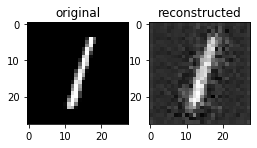

Epochs 2/10, train loss: 0.155167, test loss: 0.150151


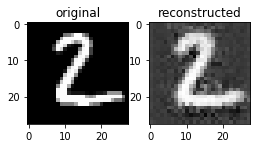

Epochs 3/10, train loss: 0.146207, test loss: 0.143356


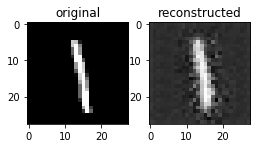

Epochs 4/10, train loss: 0.141603, test loss: 0.139607


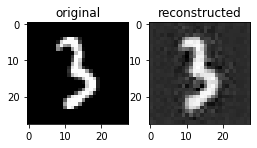

Epochs 5/10, train loss: 0.138531, test loss: 0.137214


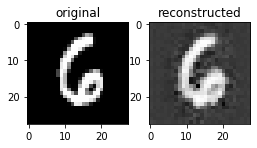

Epochs 6/10, train loss: 0.136145, test loss: 0.134881


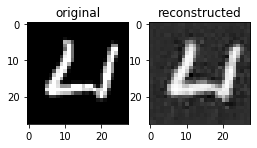

Epochs 7/10, train loss: 0.134140, test loss: 0.132865


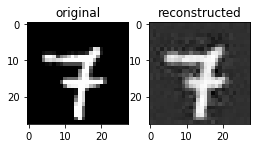

Epochs 8/10, train loss: 0.132375, test loss: 0.131159


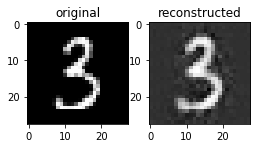

Epochs 9/10, train loss: 0.130769, test loss: 0.129528


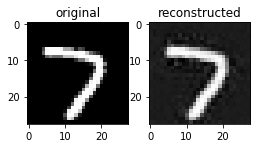

Epochs 10/10, train loss: 0.129274, test loss: 0.128350


In [12]:
train()

오토인코더를 학습하게 되면, 인코더는 나중에 이미지를 복원하기 위해 최대한 많은 핵심정보를 유지하고 노이즈를 버리는 형태로 학습이 이루어지고, 디코더는 핵심 정보를 바탕으로 이미지를 복원하는 것을 학습하게 됩니다.